In [1]:
import config, data_info, data_plot

## 3x3 Scatter Matrix

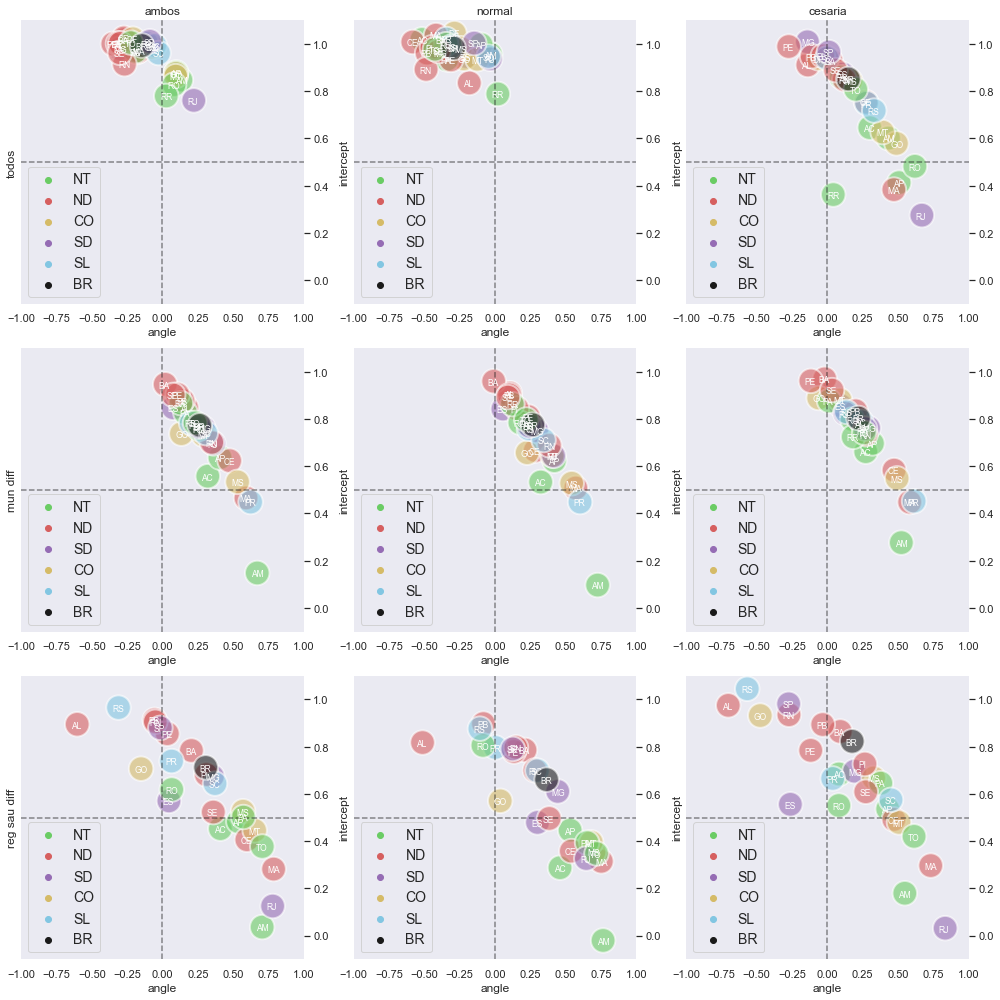

In [2]:
fnames = [
  ['uf_ano_ambos_', 'uf_ano_normal_', 'uf_ano_cesariano_'],
  ['uf_ano_ambos_c1', 'uf_ano_normal_c1', 'uf_ano_cesariano_c1'],
	['uf_ano_ambos_c3', 'uf_ano_normal_c3', 'uf_ano_cesariano_c3'],
]
data_plot.plot_scatter_matrix(data_info.get_data_matrix(fnames))